In [1]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import habitat
from habitat.core.utils import try_cv2_import

from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower
from habitat.utils.visualizations import maps
from habitat.utils.visualizations.utils import images_to_video

In [2]:
cv2 = try_cv2_import()

class SimpleRLEnv(habitat.RLEnv):
    def get_reward_range(self):
        return [-1, 1]

    def get_reward(self, observations):
        return 0

    def get_done(self, observations):
        return self.habitat_env.episode_over

    def get_info(self, observations):
        return self.habitat_env.get_metrics()

In [3]:
def draw_top_down_map(info, heading, output_size):
    top_down_map = maps.colorize_topdown_map(info["top_down_map"]["map"], 
                                             info["top_down_map"]["fog_of_war_mask"])
    original_map_size = top_down_map.shape[:2]
    map_scale = np.array((1, original_map_size[1] * 1.0 / original_map_size[0]))
    new_map_size = np.round(output_size * map_scale).astype(np.int32)
    # OpenCV expects w, h but map size is in h, w
    top_down_map = cv2.resize(top_down_map, (new_map_size[1], new_map_size[0]))

    map_agent_pos = info["top_down_map"]["agent_map_coord"]
    map_agent_pos = np.round(
        map_agent_pos * new_map_size / original_map_size
    ).astype(np.int32)
    top_down_map = maps.draw_agent(
        top_down_map,
        map_agent_pos,
        heading - np.pi / 2,
        agent_radius_px=top_down_map.shape[0] / 40,
    )
    return top_down_map

## Init config

In [4]:
config = habitat.get_config(config_paths="/habitat-api/configs/tasks/pointnav.yaml")
config.defrost()
config.TASK.MEASUREMENTS.append("TOP_DOWN_MAP")
config.TASK.SENSORS.append("HEADING_SENSOR")
config.DATASET.SCENES_DIR = '/data/scene_datasets'

# config.DATASET.DATA_PATH = '/data/datasets/pointnav/gibson/v1/{split}/{split}.json.gz'

config.DATASET.SPLIT = "train"
# config.SIMULATOR.RGB_SENSOR.NOISE_MODEL_KWARGS.intensity_constant = 0.01
# config.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = 1.0

config.DATASET.DATA_PATH = '/data/datasets/pointnav/habitat-test-scenes/v1/{split}/{split}.json.gz'
# config.SIMULATOR.SCENE = '/data/scene_datasets/habitat-test-scenes/apartment_2.glb'
config.freeze()

## Run environment

In [5]:
env = SimpleRLEnv(config=config)
goal_radius = env.episodes[0].goals[0].radius
if goal_radius is None:
    goal_radius = config.SIMULATOR.FORWARD_STEP_SIZE
follower = ShortestPathFollower(env.habitat_env.sim, goal_radius, False)
mode = "approximate_gradient"
follower.mode = mode

2020-07-19 13:57:32,618 Initializing dataset PointNav-v1
Initializing dataset PointNav-v1
2020-07-19 13:57:32,866 initializing sim Sim-v0
initializing sim Sim-v0
2020-07-19 13:57:34,186 Initializing task Nav-v0
Initializing task Nav-v0
here


## Make steps

In [6]:
!pip install moviepy

In [7]:
images = []

for j in range(10):
    env.reset();
    done = False

    for i in range(1000):
        if not done:
            best_action = follower.get_next_action(env.habitat_env.current_episode.goals[0].position)
            if best_action is None:
                best_action = 0
            observations, reward, done, info = env.step(best_action)
            im = observations["rgb"]
            top_down_map = draw_top_down_map(info, observations["heading"][0], im.shape[0])
            output_im = np.concatenate((im, top_down_map), axis=1)
            images.append(np.rollaxis(output_im, 0, 1))
        else:
            print('Episode is done!')
            break
np.shape(images)

Episode is done!
Episode is done!
Episode is done!
Episode is done!
Episode is done!
Episode is done!
Episode is done!
Episode is done!
Episode is done!
Episode is done!


(536, 256, 590, 3)

In [8]:
from moviepy.editor import ImageSequenceClip
ImageSequenceClip(list(images), fps=20).ipython_display()

t:  12%|█▏        | 63/537 [00:00<00:00, 629.05it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [9]:
env.habitat_env._current_episode.__dict__

{'episode_id': '31924',
 'scene_id': '/data/scene_datasets/gibson/Bolton.glb',
 'start_position': [0.5952060222625732,
  0.0701034814119339,
  0.3810296058654785],
 'start_rotation': [0, 0.5476448438249093, 0, 0.8367108969243742],
 'info': {'geodesic_distance': 7.514013290405273, 'difficulty': 'medium'},
 'goals': [NavigationGoal(position=[-1.3278158903121948, 0.0701034814119339, 6.49031925201416], radius=None)],
 'start_room': None,
 'shortest_paths': None}

In [11]:
info

{'distance_to_goal': 0.23183953762054443,
 'success': 0.0,
 'spl': 0.0,
 'top_down_map': {'map': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 2, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'fog_of_war_mask': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'agent_map_coord': (28, 71),
  'agent_angle': 1.5081596969467657}}

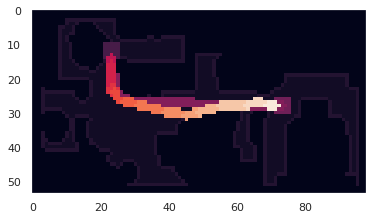

In [37]:
plt.imshow(info['top_down_map']['map'])

In [28]:
import seaborn as sns
sns.set(style='dark')